In [1]:
import os
import numpy as np
import pandas as pd
import altair as alt

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

# Visualize CSI HAR experiments

## Supplementary functions

In [2]:
EXPERIMENTS_FOLDER = "../experiments"
exp_filename = "data.csv"

SUBCARRIES_NUM_TWO_HHZ = 56
SUBCARRIES_NUM_FIVE_HHZ = 114

In [3]:
# https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/sys031fp.pdf
# Based on https://github.com/ermongroup/Wifi_Activity_Recognition/.../phase_calibration.m
def calibrate_single_phase(phases):
    phases = np.array(phases)
    difference = 0

    calibrated_phase, calibrated_phase_final = np.zeros_like(phases), np.zeros_like(phases)   
    calibrated_phase[0] = phases[0]
    
    phases_len = phases.shape[0]
    
    for i in range(1, phases_len):
        temp = phases[i]- phases[i - 1]
        
        if abs(temp) > np.pi:
            difference = difference + 1*np.sign(temp)
            
        calibrated_phase[i] = phases[i] - difference * 2 * np.pi
        
    k = (calibrated_phase[-1] - calibrated_phase[0]) / (phases_len - 1)
    b = np.mean(calibrated_phase)
    
    for i in range(phases_len):
        calibrated_phase_final[i] = calibrated_phase[i] - k * i - b
        
    return calibrated_phase_final


def calibrate_phase(phases):
    calibated_phases = np.zeros_like(phases)
    
    for i in range(phases.shape[0]):
        calibated_phases[i] = calibrate_single_phase(np.unwrap(phases[i]))
    
    return calibated_phases

def calibrate_amplitude(amplitudes, rssi=1): # Basic statistical normalization
    amplitudes = np.array(amplitudes)    
    return ((amplitudes - np.min(amplitudes)) / (np.max(amplitudes) - np.min(amplitudes))) * rssi

In [4]:
def read_csi_data_from_csv(path_to_csv, is_five_hhz=False, antenna_pairs=4):
    data = pd.read_csv(path_to_csv, header=None).values

    if is_five_hhz:
        subcarries_num = SUBCARRIES_NUM_FIVE_HHZ
    else:
        subcarries_num = SUBCARRIES_NUM_TWO_HHZ
    
    data_len = data.shape[0]
    
    amplitudes = data[:, subcarries_num*1:subcarries_num*(1 + antenna_pairs)]
    phases = data[:, subcarries_num*(1 + antenna_pairs):subcarries_num*(1 + 2*antenna_pairs)]
    
    return amplitudes, phases

# print("path_to_experiment_data: ", path_to_experiment_data)
# read_csi_data_from_csv(path_to_experiment_data)

In [161]:
import pywt


def hampel(vals_orig, k=3, t0=123, outliers_return=False):
    vals = pd.Series(vals_orig.copy())

    #Hampel Filter
    L= 1.4826
    
    rolling_median=vals.rolling(k).median()
    difference=np.abs(rolling_median-vals)
    median_abs_deviation=difference.rolling(k).median()
    threshold= t0 *L * median_abs_deviation
    outlier_idx=difference>threshold
    vals[outlier_idx]=rolling_median
    
    if outliers_return:
        return vals, outlier_idx

    return vals

def dwn_noise(vals, th=0.19):
    threshold = th # Threshold for filtering

    data = vals.copy()
#     print("data: ", data.shape)

    w = pywt.Wavelet('sym5')
    maxlev = pywt.dwt_max_level(data.shape[0], w.dec_len)
#     print("maximum level is " + str(maxlev))
    
    # Decompose into wavelet components, to the level selected:
    coeffs = pywt.wavedec(data, 'sym5', level=maxlev)
    
#     plt.figure()
    for i in range(1, len(coeffs)):
#         plt.subplot(maxlev, 1, i)
#         plt.plot(coeffs[i])
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
#         plt.plot(coeffs[i])

    datarec = pywt.waverec(coeffs, 'sym5')
    
    return datarec

def noise_reduction_all_subcarriers(amplitudes):
    data_len = amplitudes.shape[0]
    
    res = np.zeros_like(amplitudes)

    for i in range(amplitudes.shape[1]):
        res[:data_len, i] = dwn_noise(hampel(amplitudes[:, i]))[:data_len]
        
    return res

def hampel_all_subcarriers(amplitudes, k=3, t0=123):
    data_len = amplitudes.shape[0]
    
    res = np.zeros_like(amplitudes)
    outliers = []

    for i in range(amplitudes.shape[1]):
        res[:data_len, i], out = hampel(amplitudes[:, i], k, t0, outliers_return=True)[:data_len]
        outliers.append(out)
        
    return res, outliers

def cwt_all_subcarriers(amplitudes, th=0.19):
    data_len = amplitudes.shape[0]
    
    res = np.zeros_like(amplitudes)
    
    for i in range(amplitudes.shape[1]):
        res[:data_len, i] = dwn_noise(amplitudes[:, i], th)[:data_len]
        
    return res


def annotation_line( ax, xmin, xmax, y, text, ytext=0, linecolor='black', linewidth=1, fontsize=12 ):

    ax.annotate('', xy=(xmin, y), xytext=(xmax, y), xycoords='data', textcoords='data', annotation_clip=False,
            arrowprops={'arrowstyle': '|-|', 'color':linecolor, 'linewidth':linewidth})
    
    ax.annotate('', xy=(xmin, y), xytext=(xmax, y), xycoords='data', textcoords='data', annotation_clip=False,
            arrowprops={'arrowstyle': '<->', 'color':linecolor, 'linewidth':linewidth})

    xcenter = xmin + (xmax-xmin)/2
    if ytext == 0:
        ytext = y + ( ax.get_ylim()[1] - ax.get_ylim()[0] ) / 20

    ax.annotate(text, xy=(xcenter,ytext), ha='center', va='center', fontsize=fontsize, annotation_clip=False)

## 1. Channels comparison

In [6]:
experiments_data = []

experiment_name = "channels_comparison"
subexperiment_names = ["2_channels(=3)", "2_channels(=7)", "2_channels(=10)", "2_channels(=11)"]

for subexperiment_name in subexperiment_names:
    path_to_experiment_data = os.path.join(EXPERIMENTS_FOLDER, experiment_name, subexperiment_name, exp_filename)
    print("path_to_experiment_data: ", path_to_experiment_data)
    
    amplitudes, phases = read_csi_data_from_csv(path_to_experiment_data, False)
    
    experiments_data.append([amplitudes, phases])
    
# calibrate_phase(phases[:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).shape

path_to_experiment_data:  ../experiments/channels_comparison/2_channels(=3)/data.csv
path_to_experiment_data:  ../experiments/channels_comparison/2_channels(=7)/data.csv
path_to_experiment_data:  ../experiments/channels_comparison/2_channels(=10)/data.csv
path_to_experiment_data:  ../experiments/channels_comparison/2_channels(=11)/data.csv


### Amplitude plot

/home/andrew/Bachelor_thesis/CSI_OpenWrt(C)_Visuals(Python)/model_for_har/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  


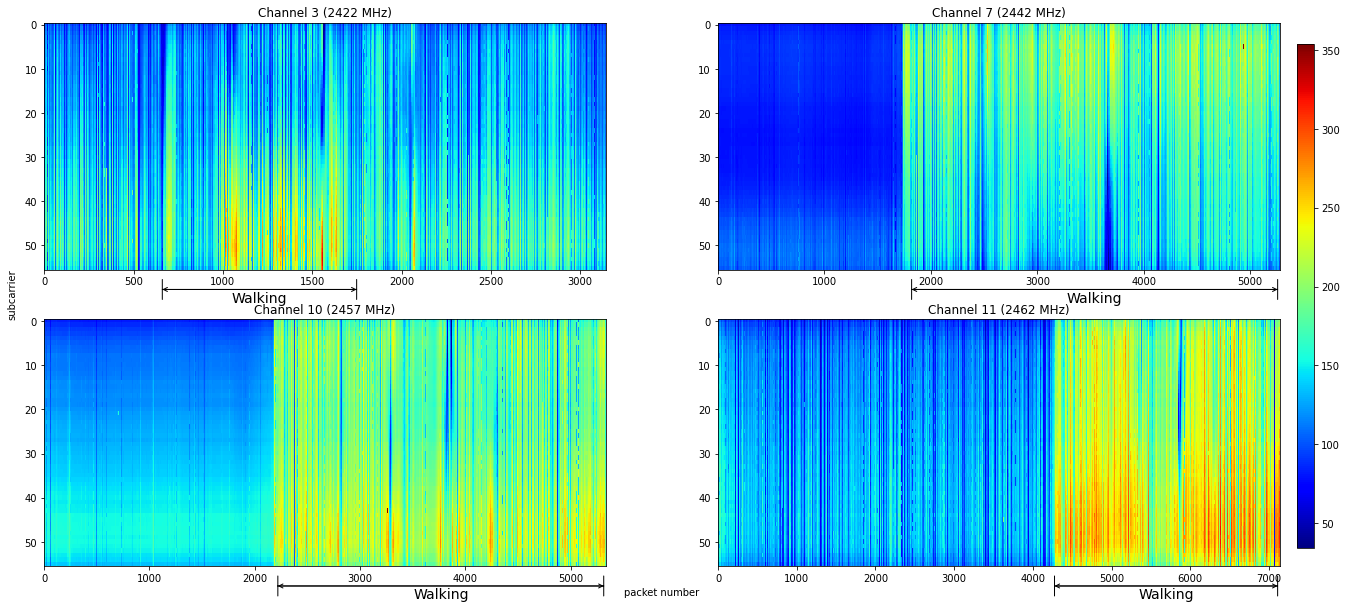

In [7]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

fig = plt.figure(figsize = (24,10))
ax = fig.add_subplot(111)

ax1 = fig.add_subplot(221)
plt.imshow(noise_reduction_all_subcarriers(experiments_data[0][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Channel 3 (2422 MHz)")
annotation_line(ax=ax1, text='Walking', xmin=650, xmax=1760, y=60, ytext=62, linewidth=1, linecolor='black', fontsize=14)

ax2 = fig.add_subplot(222)
plt.imshow(noise_reduction_all_subcarriers(experiments_data[1][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("Channel 7 (2442 MHz)")
annotation_line(ax=ax2, text='Walking', xmin=1800, xmax=experiments_data[1][0].shape[0], y=60, ytext=62, linewidth=1, linecolor='black', fontsize=14)

ax3 = fig.add_subplot(223)
plt.imshow(noise_reduction_all_subcarriers(experiments_data[2][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax3.set_title("Channel 10 (2457 MHz)")
annotation_line(ax=ax3, text='Walking', xmin=2200, xmax=experiments_data[2][0].shape[0], y=60, ytext=62, linewidth=1, linecolor='black', fontsize=14)


ax4 = fig.add_subplot(224)
im = plt.imshow(noise_reduction_all_subcarriers(experiments_data[3][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax4.set_title("Channel 11 (2462 MHz)")
annotation_line(ax=ax4, text='Walking', xmin=4250, xmax=experiments_data[3][0].shape[0], y=60, ytext=62, linewidth=1, linecolor='black', fontsize=14)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_ylabel('subcarrier')
ax.set_xlabel('packet number')

# fig.suptitle('Channels comparison for 1-to-1 antenna pair (filtered data)', fontsize=23)

fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

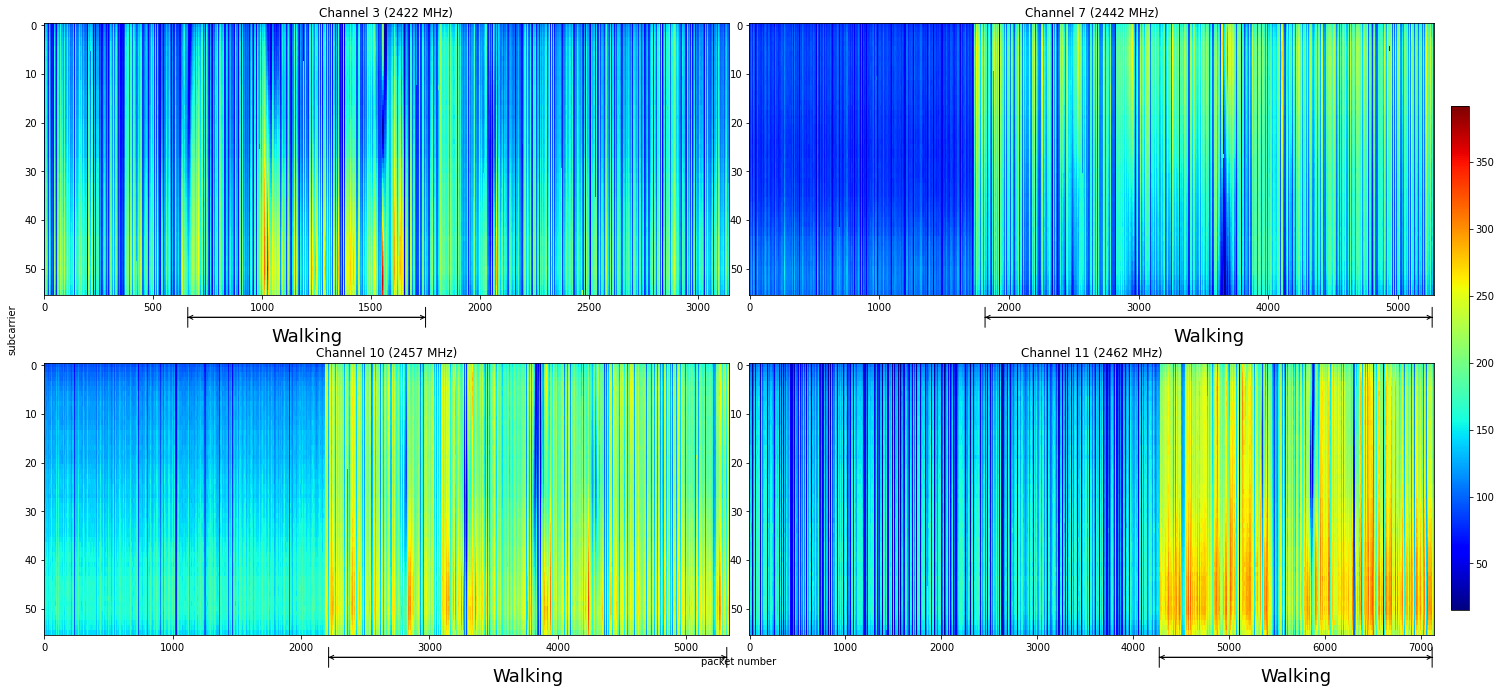

In [8]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

fig = plt.figure(figsize = (24,10))
ax = fig.add_subplot(111)

ax1 = fig.add_subplot(221)
plt.imshow((experiments_data[0][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Channel 3 (2422 MHz)")
annotation_line(ax=ax1, text='Walking', xmin=650, xmax=1760, y=60, ytext=64, linewidth=1, linecolor='black', fontsize=18)

ax2 = fig.add_subplot(222)
plt.imshow((experiments_data[1][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("Channel 7 (2442 MHz)")
annotation_line(ax=ax2, text='Walking', xmin=1800, xmax=experiments_data[1][0].shape[0], y=60, ytext=64, linewidth=1, linecolor='black', fontsize=18)

ax3 = fig.add_subplot(223)
plt.imshow((experiments_data[2][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax3.set_title("Channel 10 (2457 MHz)")
annotation_line(ax=ax3, text='Walking', xmin=2200, xmax=experiments_data[2][0].shape[0], y=60, ytext=64, linewidth=1, linecolor='black', fontsize=18)


ax4 = fig.add_subplot(224)
im = plt.imshow((experiments_data[3][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax4.set_title("Channel 11 (2462 MHz)")
annotation_line(ax=ax4, text='Walking', xmin=4250, xmax=experiments_data[3][0].shape[0], y=60, ytext=64, linewidth=1, linecolor='black', fontsize=18)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_ylabel('subcarrier')
ax.set_xlabel('packet number')

# fig.suptitle('Channels comparison for 1-to-1 antenna pair (raw data)', fontsize=23)

fig.tight_layout(pad=0.5)
fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

## 2. Channel bandwidth comparison: 20 vs 40 MHz

In [9]:
experiments_data = []

experiment_name = "20_vs_40_width"
subexperiment_names = ["3_width(=20)", "3_width(=40)", "4_width(=20)", "4_width(=40)"]

for subexperiment_name in subexperiment_names:
    path_to_experiment_data = os.path.join(EXPERIMENTS_FOLDER, experiment_name, subexperiment_name, exp_filename)
    print("path_to_experiment_data: ", path_to_experiment_data)
    
    amplitudes, phases = read_csi_data_from_csv(path_to_experiment_data, False)
    
    experiments_data.append([amplitudes, phases])

path_to_experiment_data:  ../experiments/20_vs_40_width/3_width(=20)/data.csv
path_to_experiment_data:  ../experiments/20_vs_40_width/3_width(=40)/data.csv
path_to_experiment_data:  ../experiments/20_vs_40_width/4_width(=20)/data.csv
path_to_experiment_data:  ../experiments/20_vs_40_width/4_width(=40)/data.csv


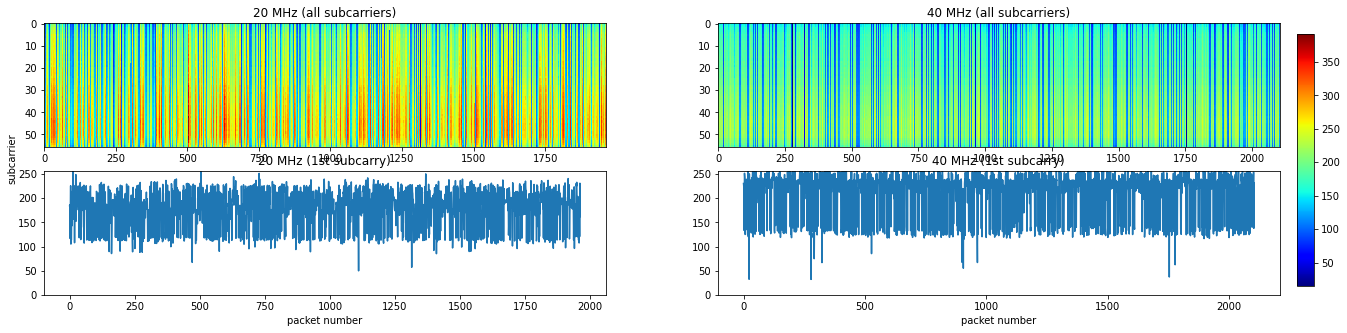

In [10]:
fig = plt.figure(figsize = (24,5))
ax = fig.add_subplot(111)

ax1 = fig.add_subplot(221)
plt.imshow((experiments_data[0][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("20 MHz (all subcarriers)")

ax2 = fig.add_subplot(222)
plt.imshow((experiments_data[1][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("40 MHz (all subcarriers)")

ax3 = fig.add_subplot(223)
plt.plot((experiments_data[0][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ])[:, 15])
ax3.set_title("20 MHz (1st subcarry)")
plt.ylim(0, 256)

ax4 = fig.add_subplot(224)
plt.plot((experiments_data[1][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ])[:, 15])
ax4.set_title("40 MHz (1st subcarry)")
plt.ylim(0, 256)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_ylabel('subcarrier')
ax3.set_xlabel('packet number')
ax4.set_xlabel('packet number')

# fig.suptitle('Channels bandwidth comparison (no activity) for 1-to-1 antenna pair', fontsize=23)

fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

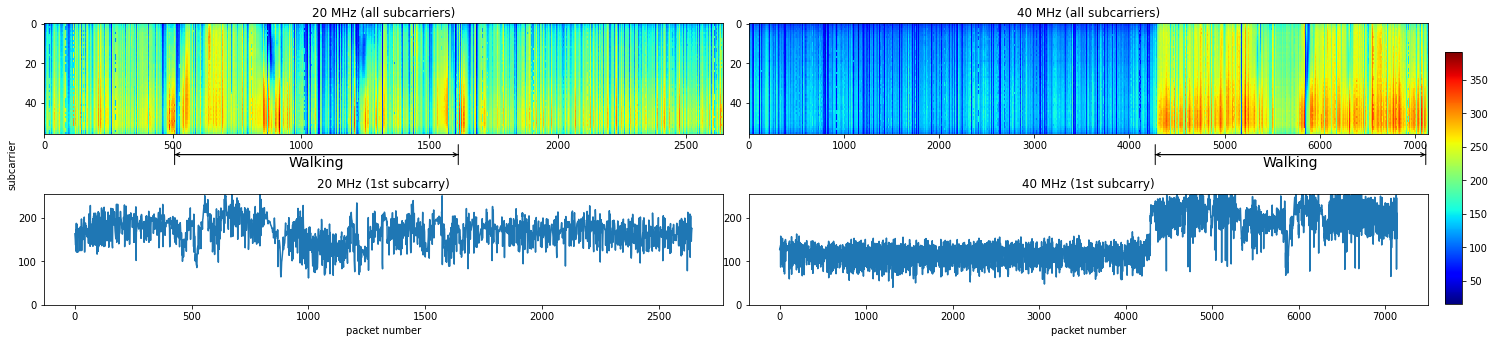

In [11]:
fig = plt.figure(figsize = (24, 5))
ax = fig.add_subplot(111)

ax1 = fig.add_subplot(221)
plt.imshow(noise_reduction_all_subcarriers(experiments_data[2][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("20 MHz (all subcarriers)")
annotation_line(ax=ax1, text='Walking', xmin=500, xmax=1620, y=66, ytext=70, linewidth=1, linecolor='black', fontsize=14)

ax2 = fig.add_subplot(222)
plt.imshow(noise_reduction_all_subcarriers(experiments_data[3][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("40 MHz (all subcarriers)")
annotation_line(ax=ax2, text='Walking', xmin=4250, xmax=experiments_data[3][0].shape[0], y=66, ytext=70, linewidth=1, linecolor='black', fontsize=14)

ax3 = fig.add_subplot(223)
plt.plot(noise_reduction_all_subcarriers(experiments_data[2][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ])[:, 15])
ax3.set_title("20 MHz (1st subcarry)")
plt.ylim(0, 256)

ax4 = fig.add_subplot(224)
plt.plot(noise_reduction_all_subcarriers(experiments_data[3][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ])[:, 15])
ax4.set_title("40 MHz (1st subcarry)")
plt.ylim(0, 256)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_ylabel('subcarrier')
ax3.set_xlabel('packet number')
ax4.set_xlabel('packet number')

# fig.suptitle('Channels bandwidth comparison (activity) for 1-to-1 antenna pair', fontsize=23)
fig.tight_layout(pad=0.5)

fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

## 3. WiFi 2.4 vs 5 HHz frequency

In [12]:
experiments_data = []

experiment_name = "24_vs_5_hhz_comparison"
subexperiment_names = ["5_freq(=5)", "5_freq(=24)", "6_freq(=5)", "6_freq(=24)"]

for index, subexperiment_name in enumerate(subexperiment_names):
    path_to_experiment_data = os.path.join(EXPERIMENTS_FOLDER, experiment_name, subexperiment_name, exp_filename)
    print("path_to_experiment_data: ", path_to_experiment_data)
    
    five_ggz = False
    if index == 0 or index == 2:
        five_ggz = True
    amplitudes, phases = read_csi_data_from_csv(path_to_experiment_data, five_ggz)
    
    experiments_data.append([amplitudes, phases])

path_to_experiment_data:  ../experiments/24_vs_5_hhz_comparison/5_freq(=5)/data.csv
path_to_experiment_data:  ../experiments/24_vs_5_hhz_comparison/5_freq(=24)/data.csv
path_to_experiment_data:  ../experiments/24_vs_5_hhz_comparison/6_freq(=5)/data.csv
path_to_experiment_data:  ../experiments/24_vs_5_hhz_comparison/6_freq(=24)/data.csv


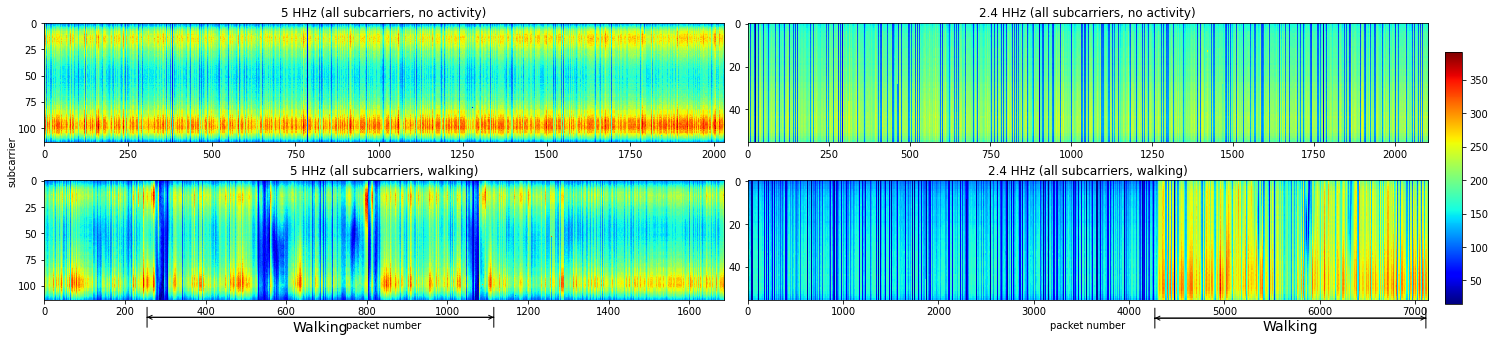

In [13]:
fig = plt.figure(figsize = (24, 5))
ax = fig.add_subplot(111)

ax1 = fig.add_subplot(221)
plt.imshow((experiments_data[0][0][:, 0*SUBCARRIES_NUM_FIVE_HHZ:1*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("5 HHz (all subcarriers, no activity)")

ax2 = fig.add_subplot(222)
plt.imshow((experiments_data[1][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("2.4 HHz (all subcarriers, no activity)")

ax3 = fig.add_subplot(223)
plt.imshow((experiments_data[2][0][:, 0*SUBCARRIES_NUM_FIVE_HHZ:1*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
annotation_line(ax=ax3, text='Walking', xmin=250, xmax=1120, y=130, ytext=140, linewidth=1, linecolor='black', fontsize=14)
ax3.set_title("5 HHz (all subcarriers, walking)")

ax4 = fig.add_subplot(224)
im = plt.imshow((experiments_data[3][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax4.set_title("2.4 HHz (all subcarriers, walking)")
annotation_line(ax=ax4, text='Walking', xmin=4250, xmax=experiments_data[3][0].shape[0], y=64, ytext=68, linewidth=1, linecolor='black', fontsize=14)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_ylabel('subcarrier')
ax3.set_xlabel('packet number')
ax4.set_xlabel('packet number')

# fig.suptitle('WiFi 2.4 vs 5 HHz frequency for 1-to-1 antenna pair', fontsize=23)
fig.tight_layout(pad=0.5)

fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

## 4. Location experiment

In [14]:
experiments_data = []

experiment_name = "routers_location"
subexperiment_names = ["1_diagonal", "2_diagonal", "1_onside", "2_onside"]

for index, subexperiment_name in enumerate(subexperiment_names):
    path_to_experiment_data = os.path.join(EXPERIMENTS_FOLDER, experiment_name, subexperiment_name, exp_filename)
    print("path_to_experiment_data: ", path_to_experiment_data)
    
    five_ggz = False
#     if index == 0 or index == 2:
#         five_ggz = True
    amplitudes, phases = read_csi_data_from_csv(path_to_experiment_data, five_ggz)
    
    experiments_data.append([amplitudes, phases])

path_to_experiment_data:  ../experiments/routers_location/1_diagonal/data.csv
path_to_experiment_data:  ../experiments/routers_location/2_diagonal/data.csv
path_to_experiment_data:  ../experiments/routers_location/1_onside/data.csv
path_to_experiment_data:  ../experiments/routers_location/2_onside/data.csv


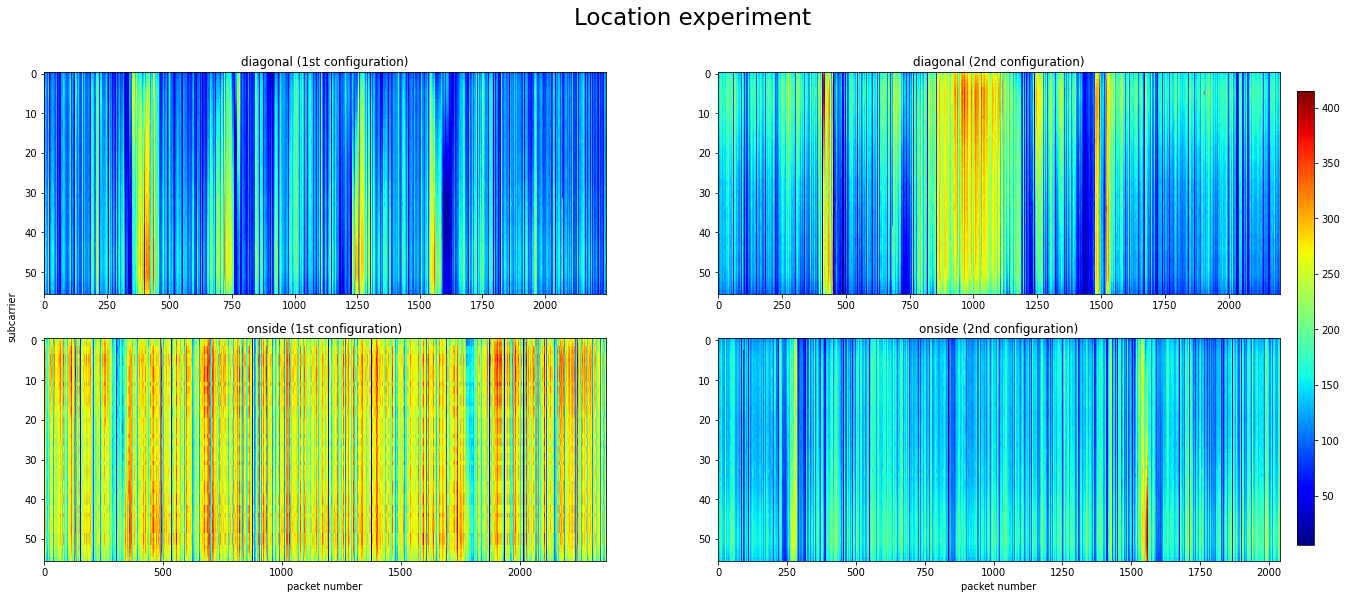

In [15]:
fig = plt.figure(figsize = (24, 9))
ax = fig.add_subplot(111)

ax1 = fig.add_subplot(221)
plt.imshow((experiments_data[0][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("diagonal (1st configuration)")

ax2 = fig.add_subplot(222)
plt.imshow((experiments_data[1][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ])[:2200, :].T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("diagonal (2nd configuration)")

ax3 = fig.add_subplot(223)
plt.imshow((experiments_data[2][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax3.set_title("onside (1st configuration)")

ax4 = fig.add_subplot(224)
im = plt.imshow((experiments_data[3][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax4.set_title("onside (2nd configuration)")

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_ylabel('subcarrier')
ax3.set_xlabel('packet number')
ax4.set_xlabel('packet number')

fig.suptitle('Location experiment', fontsize=23)

fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

## 5.Another room detection

### EASY CASE

In [16]:
experiments_data = []

experiment_name = "another_room_detection/easy/"
subexperiment_names = ["a_walking_in_received_room", "b_walking_in_transmitter_room", "c_no_walking"]

for index, subexperiment_name in enumerate(subexperiment_names):
    path_to_experiment_data = os.path.join(EXPERIMENTS_FOLDER, experiment_name, subexperiment_name, exp_filename)
    print("path_to_experiment_data: ", path_to_experiment_data)
    
    five_ggz = False
#     if index == 0 or index == 2:
#         five_ggz = True
    amplitudes, phases = read_csi_data_from_csv(path_to_experiment_data, five_ggz)
    
    experiments_data.append([amplitudes, phases])

path_to_experiment_data:  ../experiments/another_room_detection/easy/a_walking_in_received_room/data.csv
path_to_experiment_data:  ../experiments/another_room_detection/easy/b_walking_in_transmitter_room/data.csv
path_to_experiment_data:  ../experiments/another_room_detection/easy/c_no_walking/data.csv


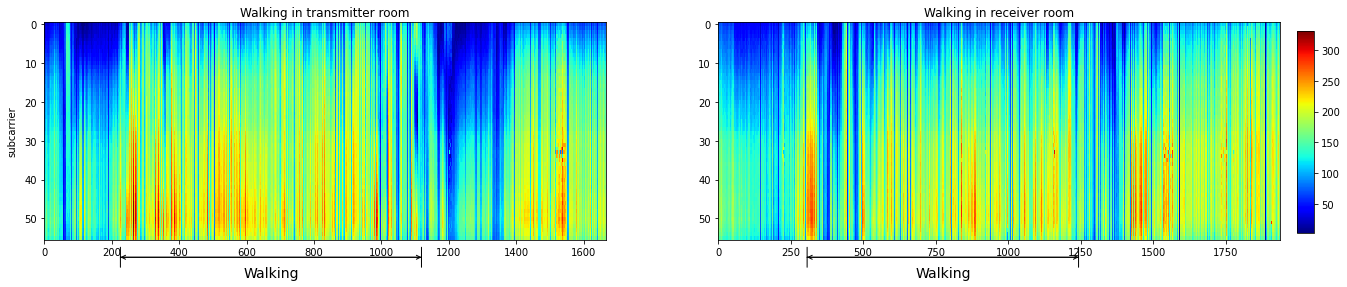

In [17]:
fig = plt.figure(figsize = (24, 4))
ax = fig.add_subplot(111)

ax1 = fig.add_subplot(121)
plt.imshow((experiments_data[0][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Walking in transmitter room")
annotation_line(ax=ax1, text='Walking', xmin=220, xmax=1125, y=60, ytext=64, linewidth=1, linecolor='black', fontsize=14)

ax2 = fig.add_subplot(122)
im = plt.imshow((experiments_data[1][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ])[:2200, :].T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("Walking in receiver room")
annotation_line(ax=ax2, text='Walking', xmin=300, xmax=1250, y=60, ytext=64, linewidth=1, linecolor='black', fontsize=14)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_ylabel('subcarrier')
ax3.set_xlabel('packet number')
ax4.set_xlabel('packet number')

# fig.suptitle('Location experiment', fontsize=23)

fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

### HARD CASE

In [18]:
experiments_data = []

experiment_name = "another_room_detection/hard/"
subexperiment_names = ["a_walking_in_another_room", "b_walking_in_tx_rx_room", "c_no_walking"]

for index, subexperiment_name in enumerate(subexperiment_names):
    path_to_experiment_data = os.path.join(EXPERIMENTS_FOLDER, experiment_name, subexperiment_name, exp_filename)
    print("path_to_experiment_data: ", path_to_experiment_data)
    
    five_ggz = True
#     if index == 0 or index == 2:
#         five_ggz = True
    amplitudes, phases = read_csi_data_from_csv(path_to_experiment_data, five_ggz)
    
    experiments_data.append([amplitudes, phases])

path_to_experiment_data:  ../experiments/another_room_detection/hard/a_walking_in_another_room/data.csv
path_to_experiment_data:  ../experiments/another_room_detection/hard/b_walking_in_tx_rx_room/data.csv
path_to_experiment_data:  ../experiments/another_room_detection/hard/c_no_walking/data.csv


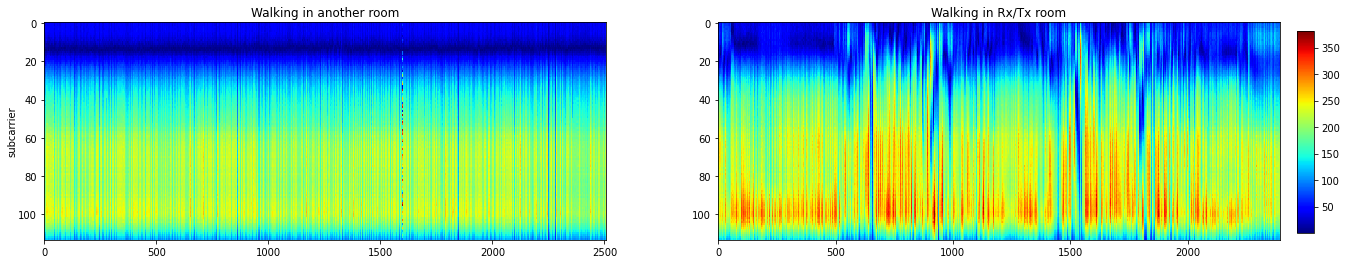

In [19]:
fig = plt.figure(figsize = (24, 4))
ax = fig.add_subplot(111)

ax1 = fig.add_subplot(121)
plt.imshow((experiments_data[0][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Walking in another room")

ax2 = fig.add_subplot(122)
im = plt.imshow((experiments_data[1][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("Walking in Rx/Tx room")

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_ylabel('subcarrier')
ax3.set_xlabel('packet number')
ax4.set_xlabel('packet number')

# fig.suptitle('Location experiment (hard case)', fontsize=23)

fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

## 6. 1x1 vs 2x2 experiment

In [20]:
experiments_data = []

experiment_name = "1x1_vs_2x2"
subexperiment_names = ["b)1tx_2rx_no_activity_onside", "b)1tx_2rx_walking_onside", "b)2tx_1rx_no_activity_onside",
                      "b)2tx_1rx_walking_onside", "b)3tx_2rx_no_activity_onside", "b)3tx_2rx_walking_onside",
                      "b)11_no_activity_onside", "b)11_walking_onside", "b)22_no_activity_onside",
                      "b)22_walking_onside"]

for index, subexperiment_name in enumerate(subexperiment_names):
    path_to_experiment_data = os.path.join(EXPERIMENTS_FOLDER, experiment_name, subexperiment_name, exp_filename)
    print("path_to_experiment_data: ", path_to_experiment_data)
    
    five_ggz = True
#     if index == 0 or index == 2:
#         five_ggz = True
    amplitudes, phases = read_csi_data_from_csv(path_to_experiment_data, five_ggz)
    
    experiments_data.append([amplitudes, phases])

path_to_experiment_data:  ../experiments/1x1_vs_2x2/b)1tx_2rx_no_activity_onside/data.csv
path_to_experiment_data:  ../experiments/1x1_vs_2x2/b)1tx_2rx_walking_onside/data.csv
path_to_experiment_data:  ../experiments/1x1_vs_2x2/b)2tx_1rx_no_activity_onside/data.csv
path_to_experiment_data:  ../experiments/1x1_vs_2x2/b)2tx_1rx_walking_onside/data.csv
path_to_experiment_data:  ../experiments/1x1_vs_2x2/b)3tx_2rx_no_activity_onside/data.csv
path_to_experiment_data:  ../experiments/1x1_vs_2x2/b)3tx_2rx_walking_onside/data.csv
path_to_experiment_data:  ../experiments/1x1_vs_2x2/b)11_no_activity_onside/data.csv
path_to_experiment_data:  ../experiments/1x1_vs_2x2/b)11_walking_onside/data.csv
path_to_experiment_data:  ../experiments/1x1_vs_2x2/b)22_no_activity_onside/data.csv
path_to_experiment_data:  ../experiments/1x1_vs_2x2/b)22_walking_onside/data.csv


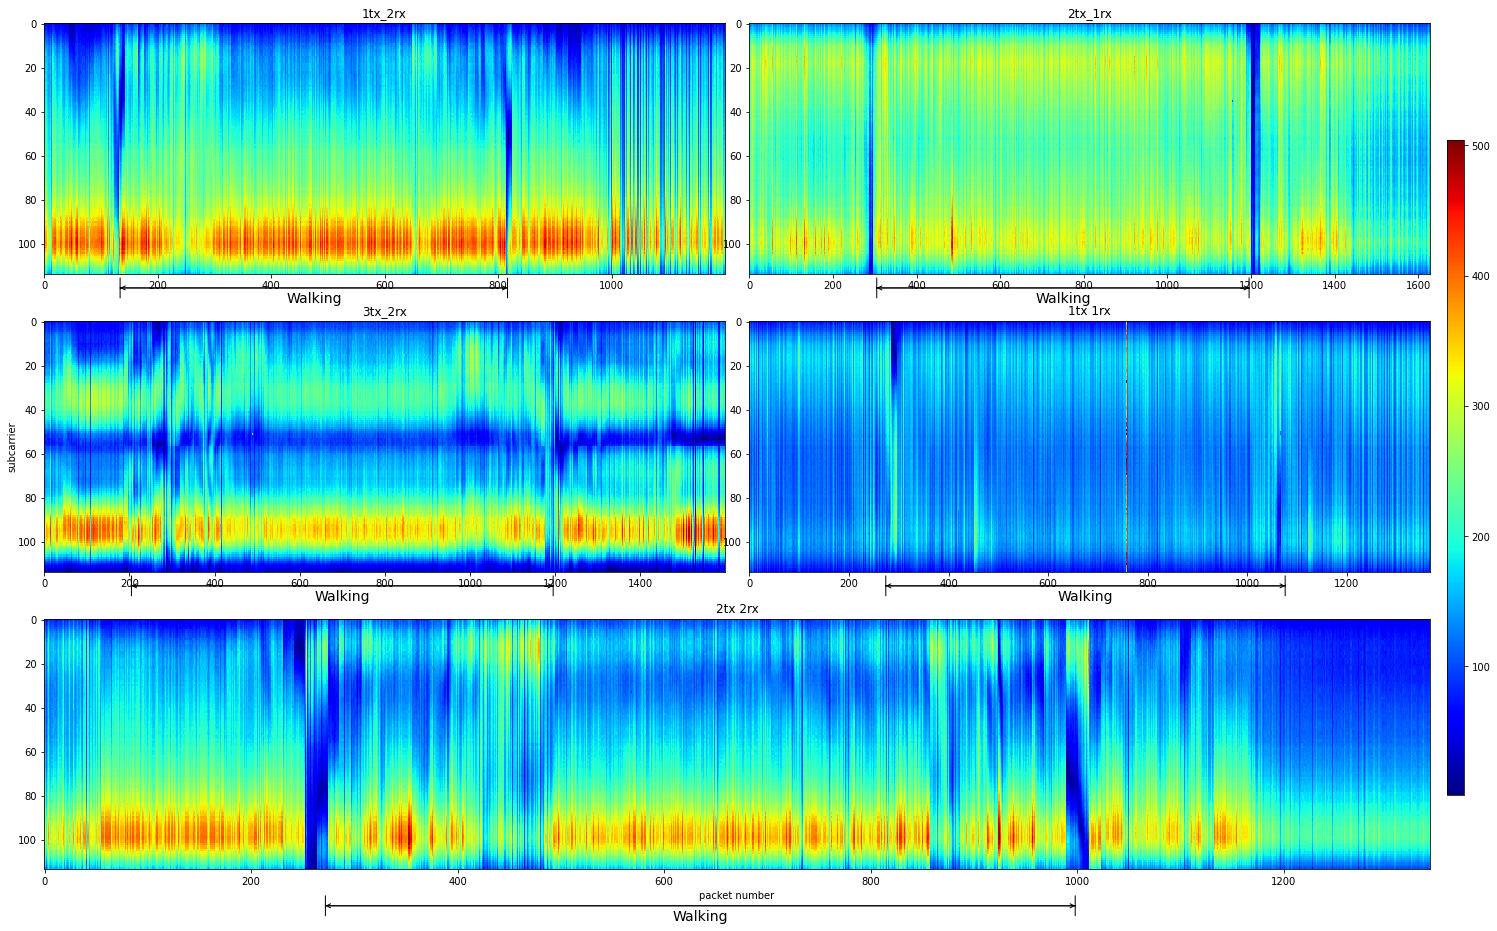

In [21]:
fig = plt.figure(figsize = (24, 13))
ax = fig.add_subplot(111)

ax1 = fig.add_subplot(321)
plt.imshow((experiments_data[1][0][:, 0*SUBCARRIES_NUM_FIVE_HHZ:1*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("1tx_2rx")
annotation_line(ax=ax1, text='Walking', xmin=130, xmax=820, y=120, ytext=125, linewidth=1, linecolor='black', fontsize=14)

ax2 = fig.add_subplot(322)
plt.imshow((experiments_data[3][0][:, 0*SUBCARRIES_NUM_FIVE_HHZ:1*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("2tx_1rx")
annotation_line(ax=ax2, text='Walking', xmin=300, xmax=1200, y=120, ytext=125, linewidth=1, linecolor='black', fontsize=14)

ax3 = fig.add_subplot(323)
plt.imshow((experiments_data[5][0][:, 0*SUBCARRIES_NUM_FIVE_HHZ:1*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax3.set_title("3tx_2rx")
annotation_line(ax=ax3, text='Walking', xmin=200, xmax=1200, y=120, ytext=125, linewidth=1, linecolor='black', fontsize=14)

ax4 = fig.add_subplot(324)
im = plt.imshow((experiments_data[7][0][:, 0*SUBCARRIES_NUM_FIVE_HHZ:1*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax4.set_title("1tx 1rx")
annotation_line(ax=ax4, text='Walking', xmin=270, xmax=1080, y=120, ytext=125, linewidth=1, linecolor='black', fontsize=14)

ax5 = fig.add_subplot(313)
im = plt.imshow((experiments_data[9][0][:, 0*SUBCARRIES_NUM_FIVE_HHZ:1*SUBCARRIES_NUM_FIVE_HHZ]).T, interpolation = "nearest", aspect = "auto", cmap="jet")
ax5.set_title("2tx 2rx")
annotation_line(ax=ax5, text='Walking', xmin=270, xmax=1000, y=130, ytext=135, linewidth=1, linecolor='black', fontsize=14)


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_ylabel('subcarrier')
# ax3.set_xlabel('packet number')
ax5.set_xlabel('packet number')

fig.tight_layout(pad=0.3)
# fig.suptitle('Different antenna number (walking)', fontsize=23)

fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

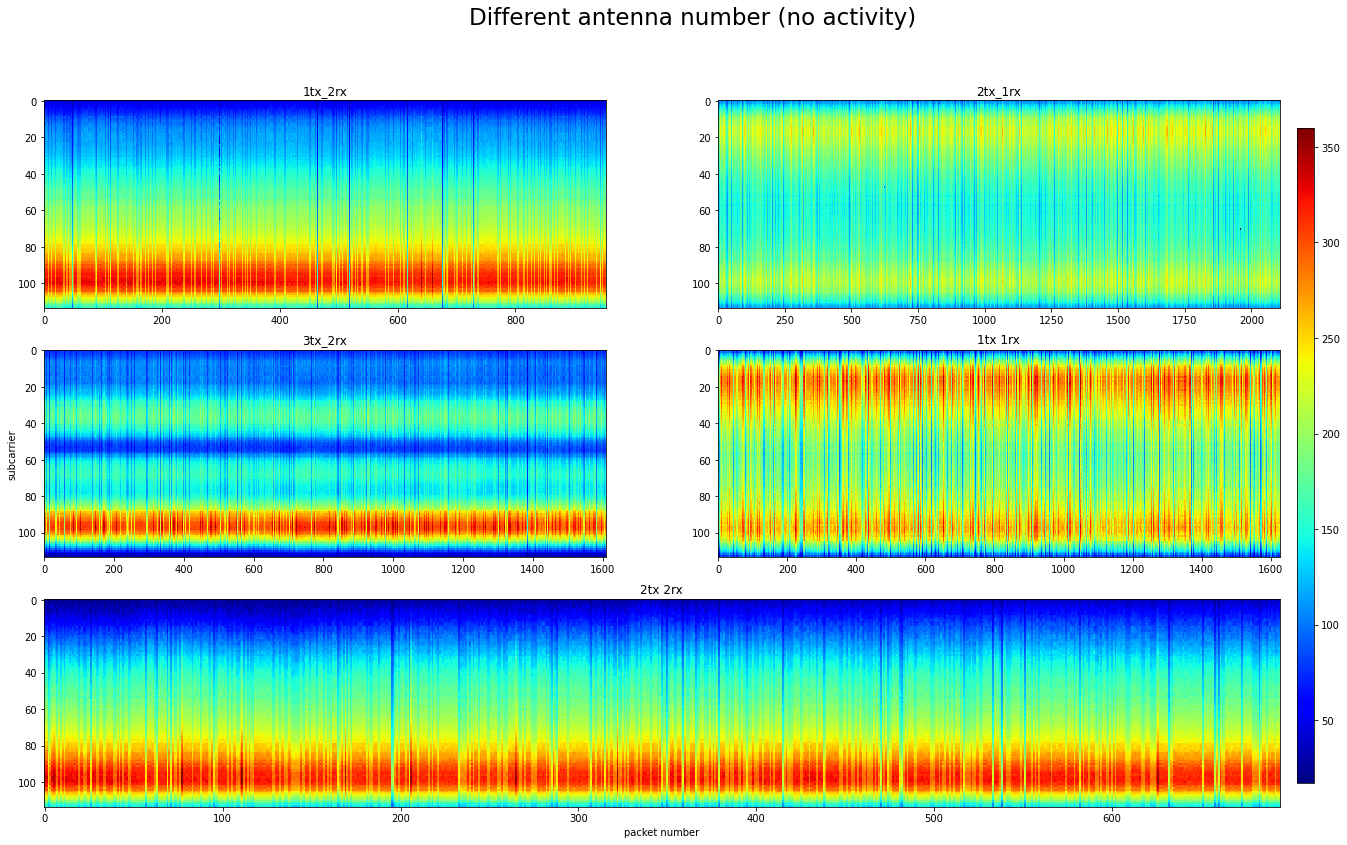

In [22]:
fig = plt.figure(figsize = (24, 13))
ax = fig.add_subplot(111)

ax1 = fig.add_subplot(321)
plt.imshow((experiments_data[0][0][:, 0*SUBCARRIES_NUM_FIVE_HHZ:1*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("1tx_2rx")

ax2 = fig.add_subplot(322)
plt.imshow((experiments_data[2][0][:, 0*SUBCARRIES_NUM_FIVE_HHZ:1*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("2tx_1rx")

ax3 = fig.add_subplot(323)
plt.imshow((experiments_data[4][0][:, 0*SUBCARRIES_NUM_FIVE_HHZ:1*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax3.set_title("3tx_2rx")

ax4 = fig.add_subplot(324)
im = plt.imshow((experiments_data[6][0][:, 0*SUBCARRIES_NUM_FIVE_HHZ:1*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax4.set_title("1tx 1rx")

ax5 = fig.add_subplot(313)
im = plt.imshow((experiments_data[8][0][:, 0*SUBCARRIES_NUM_FIVE_HHZ:1*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax5.set_title("2tx 2rx")

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_ylabel('subcarrier')
# ax3.set_xlabel('packet number')
ax5.set_xlabel('packet number')

fig.suptitle('Different antenna number (no activity)', fontsize=23)

fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [23]:
## 7.WiFi Gestures

In [24]:
experiments_data = []

experiment_name = "wifi_gestures"
subexperiment_names = ["arm_moving", "palm_moving"]

files = ["data_1.csv", "data_2.csv", "data_3.csv"]

for index, subexperiment_name in enumerate(subexperiment_names):
    for file in files:
        path_to_experiment_data = os.path.join(EXPERIMENTS_FOLDER, experiment_name, subexperiment_name, file)
        print("path_to_experiment_data: ", path_to_experiment_data)

        five_ggz = True
        amplitudes, phases = read_csi_data_from_csv(path_to_experiment_data, five_ggz)

        experiments_data.append([amplitudes, phases])

path_to_experiment_data:  ../experiments/wifi_gestures/arm_moving/data_1.csv
path_to_experiment_data:  ../experiments/wifi_gestures/arm_moving/data_2.csv
path_to_experiment_data:  ../experiments/wifi_gestures/arm_moving/data_3.csv
path_to_experiment_data:  ../experiments/wifi_gestures/palm_moving/data_1.csv
path_to_experiment_data:  ../experiments/wifi_gestures/palm_moving/data_2.csv
path_to_experiment_data:  ../experiments/wifi_gestures/palm_moving/data_3.csv


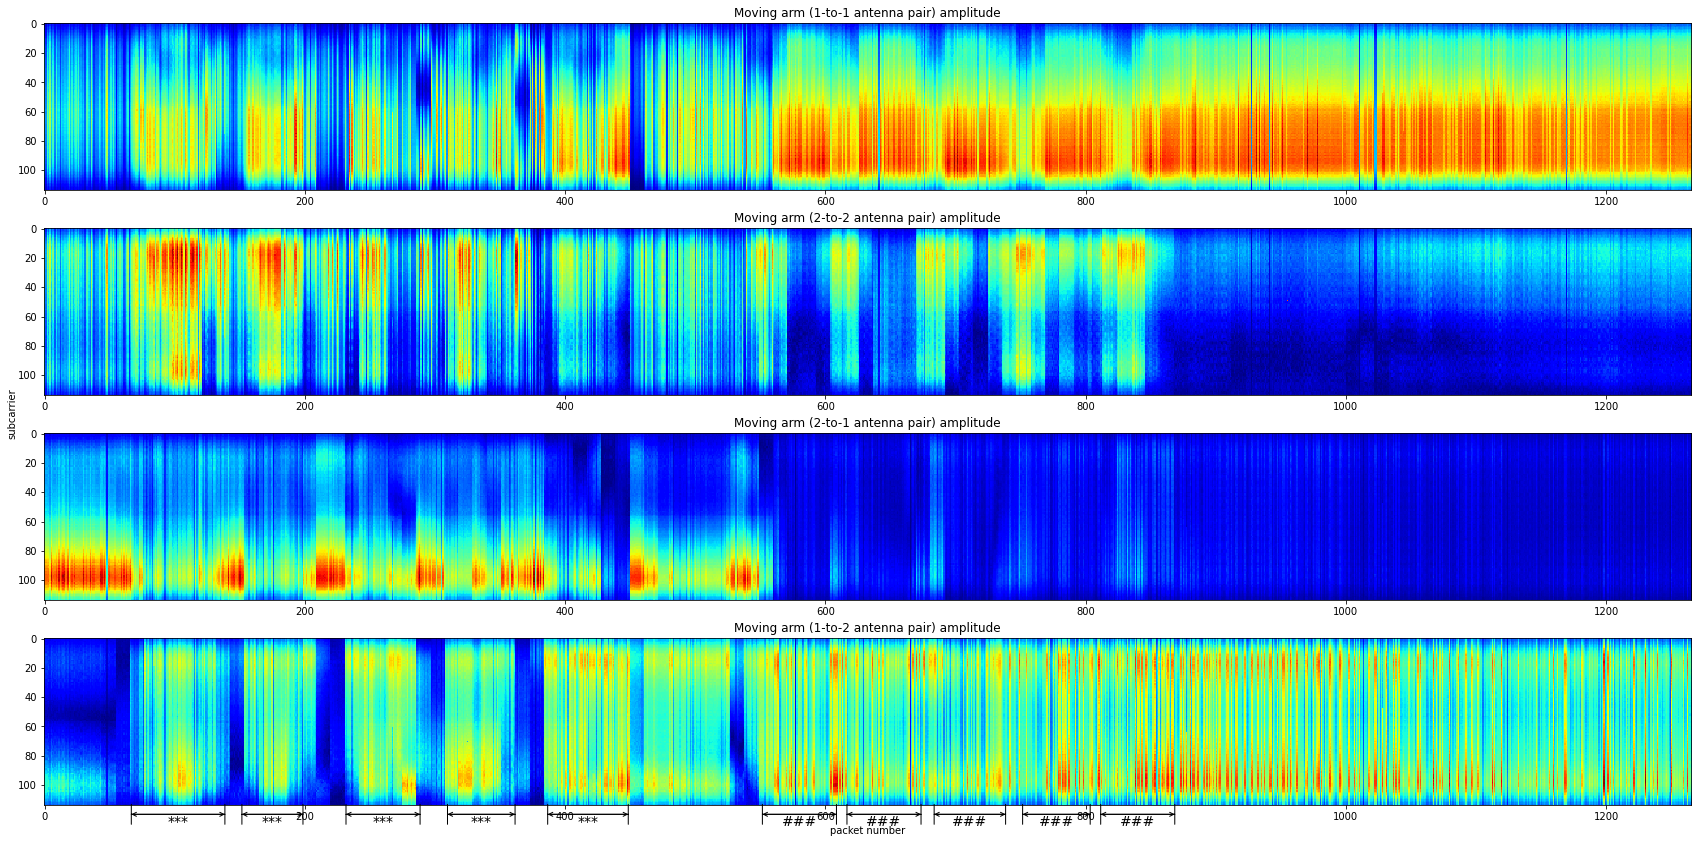

In [25]:
fig = plt.figure(figsize = (24, 12))
ax = fig.add_subplot(111)

ax1 = fig.add_subplot(411)
plt.imshow(calibrate_amplitude(experiments_data[0][0][:, 0*SUBCARRIES_NUM_FIVE_HHZ:1*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Moving arm (1-to-1 antenna pair) amplitude")

ax2 = fig.add_subplot(412)
im = plt.imshow(calibrate_amplitude(experiments_data[0][0][:, 2*SUBCARRIES_NUM_FIVE_HHZ:3*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("Moving arm (2-to-2 antenna pair) amplitude")

ax3 = fig.add_subplot(413)
im = plt.imshow(calibrate_amplitude(experiments_data[0][0][:, 3*SUBCARRIES_NUM_FIVE_HHZ:4*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax3.set_title("Moving arm (2-to-1 antenna pair) amplitude")

ax4 = fig.add_subplot(414)
im = plt.imshow(calibrate_amplitude(experiments_data[0][0][:, 1*SUBCARRIES_NUM_FIVE_HHZ:2*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax4.set_title("Moving arm (1-to-2 antenna pair) amplitude")

annotation_line(ax=ax4, text='***', xmin=65, xmax=140, y=120, ytext=125, linewidth=1, linecolor='black', fontsize=14)
annotation_line(ax=ax4, text='***', xmin=150, xmax=200, y=120, ytext=125, linewidth=1, linecolor='black', fontsize=14)
annotation_line(ax=ax4, text='***', xmin=230, xmax=290, y=120, ytext=125, linewidth=1, linecolor='black', fontsize=14)
annotation_line(ax=ax4, text='***', xmin=308, xmax=363, y=120, ytext=125, linewidth=1, linecolor='black', fontsize=14)
annotation_line(ax=ax4, text='***', xmin=385, xmax=450, y=120, ytext=125, linewidth=1, linecolor='black', fontsize=14)

annotation_line(ax=ax4, text='###', xmin=550, xmax=610, y=120, ytext=125, linewidth=1, linecolor='black', fontsize=14)
annotation_line(ax=ax4, text='###', xmin=615, xmax=675, y=120, ytext=125, linewidth=1, linecolor='black', fontsize=14)
annotation_line(ax=ax4, text='###', xmin=682, xmax=740, y=120, ytext=125, linewidth=1, linecolor='black', fontsize=14)
annotation_line(ax=ax4, text='###', xmin=750, xmax=805, y=120, ytext=125, linewidth=1, linecolor='black', fontsize=14)
annotation_line(ax=ax4, text='###', xmin=810, xmax=870, y=120, ytext=125, linewidth=1, linecolor='black', fontsize=14)

# ax4 = fig.add_subplot(414)
# plt.imshow(noise_reduction_all_subcarriers(calibrate_phase(experiments_data[0][1][:, 2*SUBCARRIES_NUM_FIVE_HHZ:3*SUBCARRIES_NUM_FIVE_HHZ])).T,interpolation = "nearest", aspect = "auto", cmap="jet")
# ax4.set_title("Moving arm (2-to-2 antenna pair) phase")
# plt.colorbar()

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_ylabel('subcarrier')
ax.set_xlabel('packet number')

fig.tight_layout(pad=0.5)
plt.show()

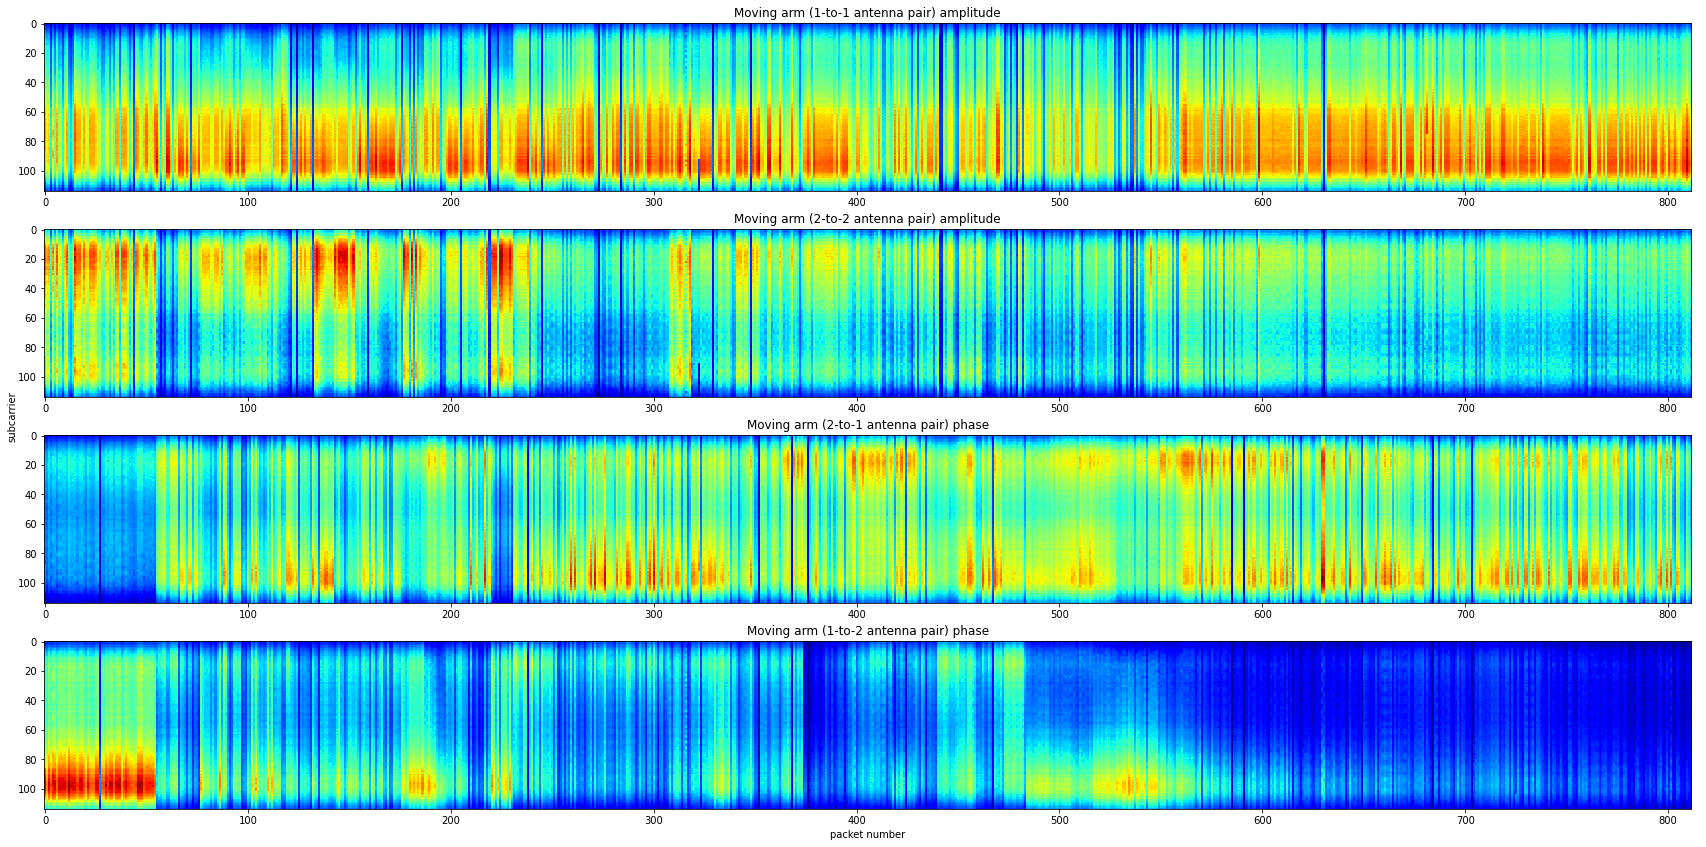

In [26]:
fig = plt.figure(figsize = (24, 12))
ax = fig.add_subplot(111)

ax1 = fig.add_subplot(411)
plt.imshow(calibrate_amplitude(experiments_data[3][0][:, 0*SUBCARRIES_NUM_FIVE_HHZ:1*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Moving arm (1-to-1 antenna pair) amplitude")

ax2 = fig.add_subplot(412)
im = plt.imshow(calibrate_amplitude(experiments_data[3][0][:, 2*SUBCARRIES_NUM_FIVE_HHZ:3*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("Moving arm (2-to-2 antenna pair) amplitude")

ax3 = fig.add_subplot(413)
im = plt.imshow(calibrate_amplitude(experiments_data[3][0][:, 1*SUBCARRIES_NUM_FIVE_HHZ:2*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax3.set_title("Moving arm (2-to-1 antenna pair) phase")

ax4 = fig.add_subplot(414)
im = plt.imshow(calibrate_amplitude(experiments_data[3][0][:, 3*SUBCARRIES_NUM_FIVE_HHZ:4*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax4.set_title("Moving arm (1-to-2 antenna pair) phase")

# plt.imshow(noise_reduction_all_subcarriers(calibrate_phase(experiments_data[0][1][:, 2*SUBCARRIES_NUM_FIVE_HHZ:3*SUBCARRIES_NUM_FIVE_HHZ])).T,interpolation = "nearest", aspect = "auto", cmap="jet")

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_ylabel('subcarrier')
ax.set_xlabel('packet number')

fig.tight_layout(pad=0.5)
plt.show()

## Data preprocessing visuals

### 1. Phase sanitization

In [41]:
experiments_data = []

experiment_name = "20_vs_40_width"
subexperiment_names = ["4_width(=40)"]

for subexperiment_name in subexperiment_names:
    path_to_experiment_data = os.path.join(EXPERIMENTS_FOLDER, experiment_name, subexperiment_name, exp_filename)
    print("path_to_experiment_data: ", path_to_experiment_data)
    
    amplitudes, phases = read_csi_data_from_csv(path_to_experiment_data, False)    
    experiments_data.append([amplitudes, phases])

path_to_experiment_data:  ../experiments/20_vs_40_width/4_width(=40)/data.csv


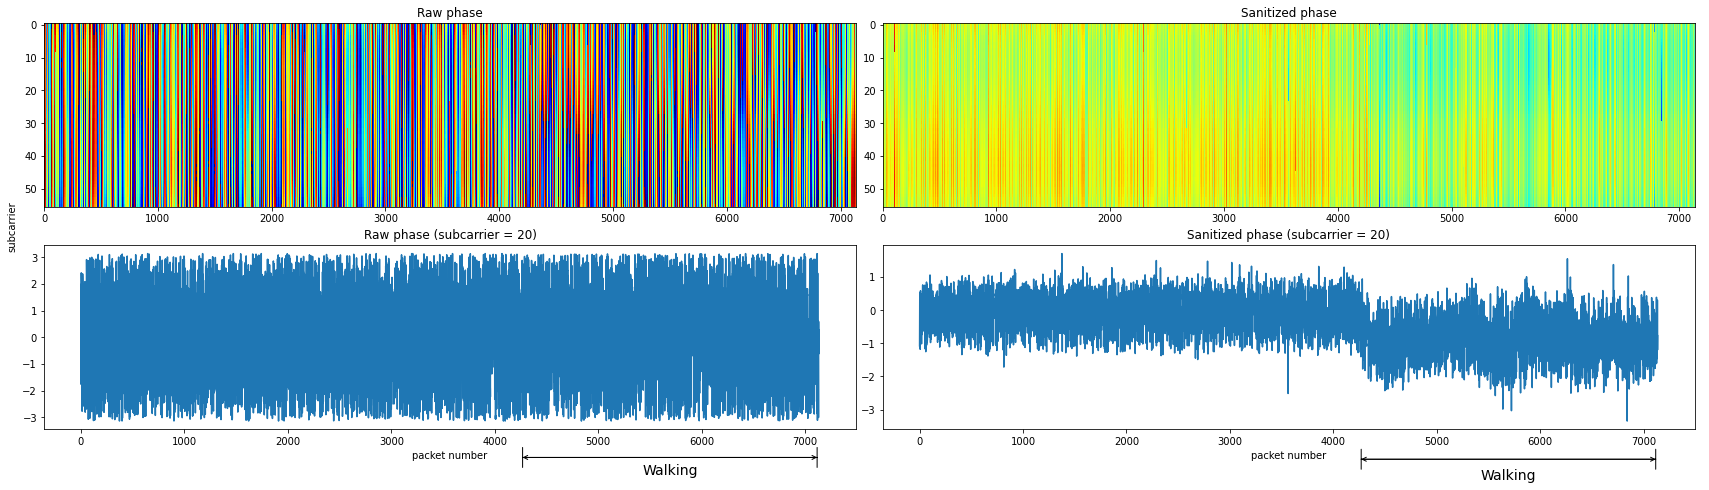

In [117]:
fig = plt.figure(figsize = (24, 7))
ax = fig.add_subplot(111)

ax1 = fig.add_subplot(221)
im = plt.imshow((experiments_data[0][1][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Raw phase")
# plt.colorbar()

ax2 = fig.add_subplot(222)
im = plt.imshow(calibrate_phase(experiments_data[0][1][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("Sanitized phase")
# plt.colorbar()

ax3 = fig.add_subplot(223)
plt.plot((experiments_data[0][1][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ])[:, 20])
ax3.set_title("Raw phase (subcarrier = 20)")
annotation_line(ax=ax3, text='Walking', xmin=4250, xmax=experiments_data[0][1].shape[0], y=-4.5, ytext=-5, linewidth=1, linecolor='black', fontsize=14)

ax4 = fig.add_subplot(224)
plt.plot(calibrate_phase(experiments_data[0][1][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ])[:, 20])
ax4.set_title("Sanitized phase (subcarrier = 20)")
annotation_line(ax=ax4, text='Walking', xmin=4250, xmax=experiments_data[0][1].shape[0], y=-4.5, ytext=-5, linewidth=1, linecolor='black', fontsize=14)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_ylabel('subcarrier')
ax3.set_xlabel('packet number')
ax4.set_xlabel('packet number')

# fig.suptitle('WiFi 2.4 vs 5 HHz frequency for 1-to-1 antenna pair', fontsize=23)
fig.tight_layout(pad=0.5)

plt.show()

### 2. Hampler outlier indentification

In [98]:
experiments_data = []

experiment_name = "20_vs_40_width"
subexperiment_names = ["4_width(=40)"]

for subexperiment_name in subexperiment_names:
    path_to_experiment_data = os.path.join(EXPERIMENTS_FOLDER, experiment_name, subexperiment_name, exp_filename)
    print("path_to_experiment_data: ", path_to_experiment_data)
    
    amplitudes, phases = read_csi_data_from_csv(path_to_experiment_data, False)    
    experiments_data.append([amplitudes, phases])

path_to_experiment_data:  ../experiments/20_vs_40_width/4_width(=40)/data.csv


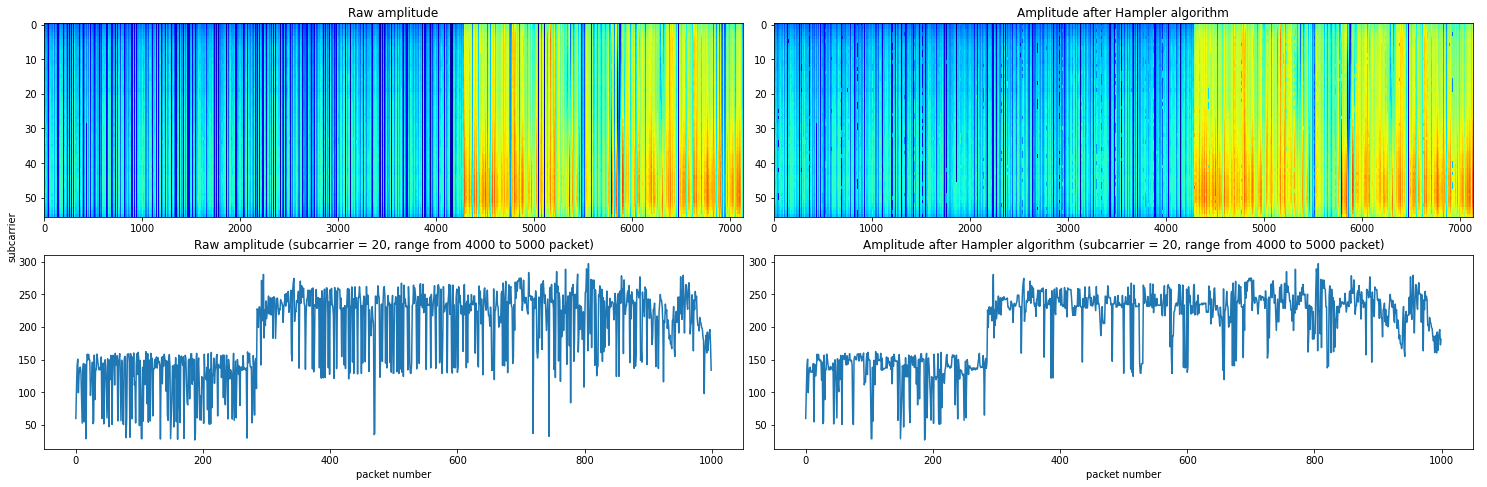

In [150]:
fig = plt.figure(figsize = (21, 7))
ax = fig.add_subplot(111)

amplitude = experiments_data[0][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]
h_amplitude, outliers = hampel_all_subcarriers(amplitude, k=5, t0=2)

ax1 = fig.add_subplot(221)
im = plt.imshow((amplitude).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Raw amplitude")

ax2 = fig.add_subplot(222)
im = plt.imshow(h_amplitude.T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("Amplitude after Hampler algorithm")

ax3 = fig.add_subplot(223)
plt.plot((amplitude)[4000:5000, 20])
ax3.set_title("Raw amplitude (subcarrier = 20, range from 4000 to 5000 packet)")
l
ax4 = fig.add_subplot(224)
plt.plot(h_amplitude[4000:5000, 20])
ax4.set_title("Amplitude after Hampler algorithm (subcarrier = 20, range from 4000 to 5000 packet)")

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_ylabel('subcarrier')
ax3.set_xlabel('packet number')
ax4.set_xlabel('packet number')

fig.tight_layout(pad=0.5)
plt.show()

In [133]:
outliers[20].to_numpy().sum()

2056

### 3. CWT noise reduction

In [ ]:
dataset = CSIDataset([
    "../dataset/bedroom_lviv/4",
], window_size=-1)

In [158]:
dataset_amp = dataset[0][0][:, 0:456]

In [160]:
dataset_amp.shape

(7661, 456)

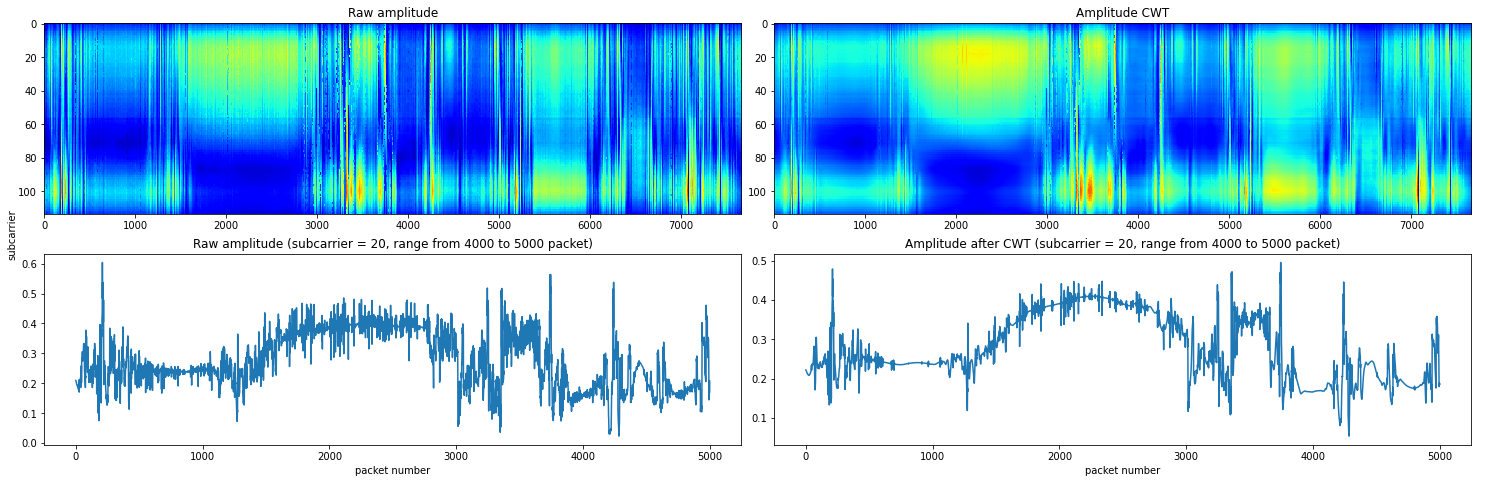

In [171]:
fig = plt.figure(figsize = (21, 7))
ax = fig.add_subplot(111)

amplitude = dataset_amp[:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_FIVE_HHZ]
cwt_amplitude = cwt_all_subcarriers(amplitude, th=0.2)

ax1 = fig.add_subplot(221)
im = plt.imshow((amplitude).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Raw amplitude")

ax2 = fig.add_subplot(222)
im = plt.imshow(cwt_amplitude.T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("Amplitude CWT")

ax3 = fig.add_subplot(223)
plt.plot((amplitude)[0:5000, 20])
ax3.set_title("Raw amplitude (subcarrier = 20, range from 4000 to 5000 packet)")

ax4 = fig.add_subplot(224)
plt.plot(cwt_amplitude[0:5000, 20])
ax4.set_title("Amplitude after CWT (subcarrier = 20, range from 4000 to 5000 packet)")

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_ylabel('subcarrier')
ax3.set_xlabel('packet number')
ax4.set_xlabel('packet number')

fig.tight_layout(pad=0.7)
plt.show()

NameError: name 'l' is not defined

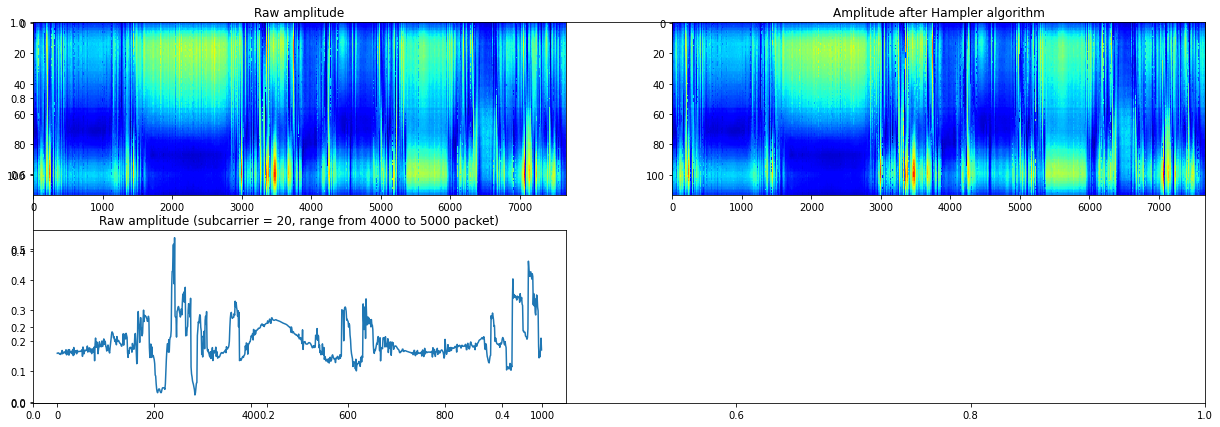

In [172]:
fig = plt.figure(figsize = (21, 7))
ax = fig.add_subplot(111)

amplitude = dataset_amp[:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_FIVE_HHZ]
h_amplitude, outliers = hampel_all_subcarriers(amplitude, k=5, t0=2)

ax1 = fig.add_subplot(221)
im = plt.imshow((amplitude).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Raw amplitude")

ax2 = fig.add_subplot(222)
im = plt.imshow(h_amplitude.T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("Amplitude after Hampler algorithm")

ax3 = fig.add_subplot(223)
plt.plot((amplitude)[4000:5000, 20])
ax3.set_title("Raw amplitude (subcarrier = 20, range from 4000 to 5000 packet)")

ax4 = fig.add_subplot(224)
plt.plot(h_amplitude[4000:5000, 20])
ax4.set_title("Amplitude after Hampler algorithm (subcarrier = 20, range from 4000 to 5000 packet)")

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_ylabel('subcarrier')
ax3.set_xlabel('packet number')
ax4.set_xlabel('packet number')

fig.tight_layout(pad=0.5)
plt.show()

In [27]:
# ax1 = plt.subplot(611)
# plt.plot(pca_data2[xmin:xmax,0])
# #plt.plot(pca_data2[2500:17500,0])
# ax1.set_title("PCA 1st component")
#
# ax2 = plt.subplot(612)
# plt.plot(pca_data2[xmin:xmax,1])
# #plt.plot(pca_data2[2500:17500,1])
# ax2.set_title("PCA 2nd component")
#
# ax3 = plt.subplot(613)
# plt.plot(pca_data2[xmin:xmax,2])
# #plt.plot(pca_data2[2500:17500,2])
# ax3.set_title("PCA 3rd component")
#
# ax4 = plt.subplot(614)
# plt.plot(pca_data2[xmin:xmax,3])
# #plt.plot(pca_data2[2500:17500,3])
# ax4.set_title("PCA 4th component")
#
# ax5 = plt.subplot(615)
# plt.plot(pca_data2[xmin:xmax,4])
# #plt.plot(pca_data2[2500:17500,4])
# ax5.set_title("PCA 5th component")
#
# ax6 = plt.subplot(616)
# plt.plot(pca_data2[xmin:xmax,5])
# #plt.plot(pca_data2[2500:17500,5])
# ax6.set_title("PCA 6th component")
#
# plt.show()

### Amplitude (normalized) plot

In [28]:
# fig = plt.figure(figsize = (24,10))

# ax1 = plt.subplot(411)
# plt.imshow(calibrate_amplitude(amplitudes[:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ], 1).T,interpolation = "nearest", aspect = "auto", cmap="jet")
# ax1.set_title("Antenna1 Standartized Amplitude")
# plt.colorbar()

# ax2 = plt.subplot(412)
# plt.imshow(calibrate_amplitude(amplitudes[:, 1*SUBCARRIES_NUM_TWO_HHZ:2*SUBCARRIES_NUM_TWO_HHZ], 1).T,interpolation = "nearest", aspect = "auto", cmap="jet")
# ax2.set_title("Antenna2 Standartized Amplitude")
# plt.colorbar()

# ax3 = plt.subplot(413)
# plt.imshow(calibrate_amplitude(amplitudes[:, 2*SUBCARRIES_NUM_TWO_HHZ:3*SUBCARRIES_NUM_TWO_HHZ], 1).T,interpolation = "nearest", aspect = "auto", cmap="jet")
# ax3.set_title("Antenna3 Standartized Amplitude")
# plt.colorbar()

# ax4 = plt.subplot(414)
# plt.imshow(calibrate_amplitude(amplitudes[:, 3*SUBCARRIES_NUM_TWO_HHZ:4*SUBCARRIES_NUM_TWO_HHZ], 1).T,interpolation = "nearest", aspect = "auto", cmap="jet")
# ax4.set_title("Antenna4 Standartized Amplitude")
# plt.colorbar()
# plt.show()


### Phase plot

In [29]:
# fig = plt.figure(figsize = (24,10))

# ax1 = plt.subplot(411)
# plt.imshow(phases[:,0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ].T,interpolation = "nearest", aspect = "auto", cmap="jet")
# ax1.set_title("Antenna1 Phase")
# plt.colorbar()

# ax2 = plt.subplot(412)
# plt.imshow(phases[:,1*SUBCARRIES_NUM_TWO_HHZ:2*SUBCARRIES_NUM_TWO_HHZ].T,interpolation = "nearest", aspect = "auto", cmap="jet")
# ax2.set_title("Antenna2 Phase")
# plt.colorbar()

# ax3 = plt.subplot(413)
# plt.imshow(phases[:,2*SUBCARRIES_NUM_TWO_HHZ:3*SUBCARRIES_NUM_TWO_HHZ].T,interpolation = "nearest", aspect = "auto", cmap="jet")
# ax3.set_title("Antenna3 Phase")
# plt.colorbar()

# ax4 = plt.subplot(414)
# plt.imshow(phases[:,3*SUBCARRIES_NUM_TWO_HHZ:4*SUBCARRIES_NUM_TWO_HHZ].T,interpolation = "nearest", aspect = "auto", cmap="jet")
# ax4.set_title("Antenna4 Phase")
# plt.colorbar()
# plt.show()


### Phase (calibrated) plot

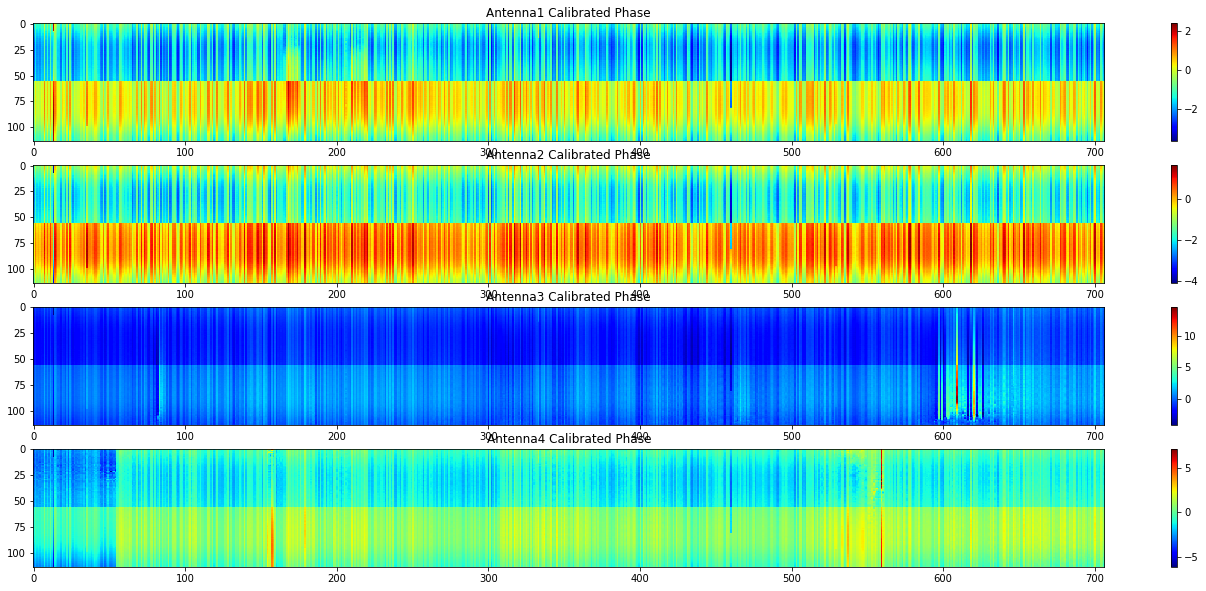

In [30]:
# fig = plt.figure(figsize = (24,10))

# ax1 = plt.subplot(411)
# plt.imshow(calibrate_phase(phases[:,0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
# ax1.set_title("Antenna1 Calibrated Phase")
# plt.colorbar()

# ax2 = plt.subplot(412)
# plt.imshow(calibrate_phase(phases[:,1*SUBCARRIES_NUM_TWO_HHZ:2*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
# ax2.set_title("Antenna2 Calibrated Phase")
# plt.colorbar()

# ax3 = plt.subplot(413)
# plt.imshow(calibrate_phase(phases[:,2*SUBCARRIES_NUM_TWO_HHZ:3*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
# ax3.set_title("Antenna3 Calibrated Phase")
# plt.colorbar()

# ax4 = plt.subplot(414)
# plt.imshow(calibrate_phase(phases[:,3*SUBCARRIES_NUM_TWO_HHZ:4*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
# ax4.set_title("Antenna4 Calibrated Phase")
# plt.colorbar()
# plt.show()


fig = plt.figure(figsize = (24,10))

ax1 = plt.subplot(411)
plt.imshow(calibrate_phase(phases[:,0*SUBCARRIES_NUM_FIVE_HHZ:1*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Antenna1 Calibrated Phase")
plt.colorbar()

ax2 = plt.subplot(412)
plt.imshow(calibrate_phase(phases[:,1*SUBCARRIES_NUM_FIVE_HHZ:2*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("Antenna2 Calibrated Phase")
plt.colorbar() 

ax3 = plt.subplot(413)
plt.imshow(calibrate_phase(phases[:,2*SUBCARRIES_NUM_FIVE_HHZ:3*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax3.set_title("Antenna3 Calibrated Phase")
plt.colorbar()

ax4 = plt.subplot(414)
plt.imshow(calibrate_phase(phases[:,3*SUBCARRIES_NUM_FIVE_HHZ:4*SUBCARRIES_NUM_FIVE_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax4.set_title("Antenna4 Calibrated Phase")
plt.colorbar()
plt.show()


## Using custom CSIDATASET class

In [154]:
import sys
sys.path.append("..") # to import from parent directory

from dataset import read_all_data, CSIDataset, read_all_data_from_files

In [155]:
dataset = CSIDataset([
    "../dataset/bedroom_lviv/4",
], window_size=-1)

In [156]:
dataset[0][0].shape

(7661, 468)

In [34]:
dataset[0][1].shape

AttributeError: 'int' object has no attribute 'shape'

In [ ]:
SUBCARRIES_NUM_TWO_HHZ = 56
SUBCARRIES_NUM_FIVE_HHZ = 114


In [ ]:
dataset_amp = dataset[0][0][:, 0:456]
dataset_phase = dataset[0][0][:, 456:]
dataset_labels = dataset[0][1]

fig = plt.figure(figsize = (24,10))
ax1 = plt.subplot(411)
plt.imshow(dataset_amp[:,0*SUBCARRIES_NUM_FIVE_HHZ:1*SUBCARRIES_NUM_FIVE_HHZ].T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Antenna1 Amplitude")
plt.colorbar()

ax2 = plt.subplot(412)
plt.imshow(dataset_amp[:,1*SUBCARRIES_NUM_FIVE_HHZ:2*SUBCARRIES_NUM_FIVE_HHZ].T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("Antenna2 Amplitude")
plt.colorbar() 

ax3 = plt.subplot(413)
plt.imshow(dataset_amp[:,2*SUBCARRIES_NUM_FIVE_HHZ:3*SUBCARRIES_NUM_FIVE_HHZ].T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax3.set_title("Antenna3 Amplitude")
plt.colorbar()

ax4 = plt.subplot(414)
plt.imshow(dataset_amp[:,3*SUBCARRIES_NUM_FIVE_HHZ:4*SUBCARRIES_NUM_FIVE_HHZ].T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax4.set_title("Antenna4 Amplitude")
plt.colorbar()
plt.show()


fig = plt.figure(figsize = (24,10))
ax1 = plt.subplot(411)
plt.imshow(dataset_phase[:,0*SUBCARRIES_NUM_FIVE_HHZ:1*SUBCARRIES_NUM_FIVE_HHZ].T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Antenna1 Calibrated Phase")
plt.colorbar()

ax2 = plt.subplot(412)
plt.imshow(dataset_phase[:,1*SUBCARRIES_NUM_FIVE_HHZ:2*SUBCARRIES_NUM_FIVE_HHZ].T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("Antenna2 Calibrated Phase")
plt.colorbar() 

ax3 = plt.subplot(413)
plt.imshow(dataset_phase[:,2*SUBCARRIES_NUM_FIVE_HHZ:3*SUBCARRIES_NUM_FIVE_HHZ].T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax3.set_title("Antenna3 Calibrated Phase")
plt.colorbar()

ax4 = plt.subplot(414)
plt.imshow(dataset_phase[:,3*SUBCARRIES_NUM_FIVE_HHZ:4*SUBCARRIES_NUM_FIVE_HHZ].T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax4.set_title("Antenna4 Calibrated Phase")
plt.colorbar()
plt.show()


In [ ]:
plt.hist(dataset_labels)
plt.show()

In [ ]:
####
####
# TODO
# outlier removal
# DWT
# 
# Add PCA to dataset
#
#
####

In [ ]:


dataset_amp = dataset[0][0][300:1500, 0:456]

amp1 = dataset_amp[:, 0:SUBCARRIES_NUM_FIVE_HHZ]
amp1_without_outliers = hampel(amp1[:, 0])

print(amp1_without_outliers.to_numpy())

fig = plt.figure(figsize = (24,10))
ax1 = plt.subplot(211)
plt.plot(amp1.T[0])


ax1.set_title("Raw data")

ax2 = plt.subplot(212)
plt.plot(amp1_without_outliers)
ax2.set_title("HAMPLER algo")


In [ ]:



dataset_amp = dataset[0][0][:, 0:456]
amp1 = dataset_amp[:7000, 0:SUBCARRIES_NUM_FIVE_HHZ]

amp1_without_outliers = hampel(amp1.T[0])
amp1_with_dwt = dwn_noise(amp1_without_outliers)

print(amp1.shape)
print(amp1_without_outliers.shape)
print(amp1_with_dwt.shape)

fig = plt.figure(figsize = (24,10))
ax1 = plt.subplot(211)
plt.plot(amp1_without_outliers)
ax1.set_title("HAMPLER")

ax2 = plt.subplot(212)
plt.plot(amp1_with_dwt)
ax2.set_title("DWT Noise removal")


In [ ]:
dataset_amp
from sklearn import decomposition

pca = decomposition.PCA(n_components=3)

dataset_amp = dataset[0][0][:, 0:456]
dataset_phase = dataset[0][0][:, 456:]
dataset_labels = dataset[0][1]

fig = plt.figure(figsize = (24,10))
ax1 = plt.subplot(411)
plt.imshow(dataset_amp[:,0*SUBCARRIES_NUM_FIVE_HHZ:1*SUBCARRIES_NUM_FIVE_HHZ].T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Antenna1 Amplitude")
plt.colorbar()

amp1_pca = pca.fit_transform(dataset_amp[:,2*SUBCARRIES_NUM_FIVE_HHZ:3*SUBCARRIES_NUM_FIVE_HHZ])

print("amp1_pca: ", amp1_pca.shape)
print("amp1_pca.T: ", amp1_pca.T.shape)

ax2 = plt.subplot(412)
plt.plot(calibrate_amplitude(amp1_pca.T[0], 1))
ax2.set_title("PCA1")


ax3 = plt.subplot(413)
plt.plot(calibrate_amplitude(amp1_pca.T[1], 1))
ax3.set_title("PCA2")

ax4 = plt.subplot(414)
plt.plot(calibrate_amplitude(amp1_pca.T[2], 1))
ax4.set_title("PCA3")